## Loss prediction for Active Learning for DETR TB Bacilli Detection

This notebook is used to predict the loss of our trained DETR model for the next iteration of active learning.

The loss is predicted using a Neural Network that takes as input the features of the current model from different modules of the DETR model and outputs the (predicted) loss.

We make experiments with different combinations of features and also include other ML loss-prediction models (e.g. Random Forest, Linear Regression) for comparison.

Advantages of predicting the loss of the model for active learning:

- The loss of a NN encodes information about the model's performance on the training data. Therefore, the loss can be used as a proxy for the model's performance on the test data. This is useful for active learning since we want to select the images that will improve the model's performance on the test data.
- We can predict the loss of the model for the next iteration of active learning and select the images with the highest loss for annotation.
- While the learned loss-prediction model is model-specific, the same method can be used for any DNN-based architecture (e.g. Faster R-CNN, YOLO, etc.) since they are all based in computing the loss of the model with respect to an image.
- Since the loss-prediction model is trained on the features of the model, it can be used to predict the loss of the model for any dataset (e.g. different datasets of TB images, different datasets of images of other diseases, etc.).
- The loss-prediction model can be made lightweight when we don't include all the features of the model. This makes it more efficient than other methods (i.e. those based on uncertainty sampling) that require to compute the loss of the model for all the images in the dataset, which is very useful when we have a very large amount of unlabeled samples but low computational resources.

Also importantly:

- Rather than sampling individual image by predicting their loss, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is very useful when we operate with models that are trained (or pre-trained) with a relatively large batch size. CNNs for example, are usually trained with a batch size of 32 or 64 images. Therefore, these models tend to not learn based on individual images but on batches of images. Therefore, the uncertainty of the model for a single image is not very informative, nor useful in an active learning setting (Note: you should try to confirm this empirically). However, the loss of the model for a batch of images is more informative (Incude experiments using different batch sizes to confirm this empirically). Therefore, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is more informative than sampling individual images and predicting their loss.

Disadvantages of predicting the loss of the model for active learning:

- The loss of the model is not a perfect proxy for the model's performance on the test data. Therefore, the images with the highest loss might not be the best images to annotate.
- The loss-prediction model is model-specific and might not be useful for other models (e.g. Faster R-CNN, YOLO, etc.). Thus, it requires higher initial computational cost to train the loss-prediction model (but might be more efficient in the long run since afterwards it is not necessary to make inference on the model for all samples).

Method based on the paper: [Learning Loss for Active Learning](https://arxiv.org/pdf/1905.03677.pdf)

In [1]:
# imports and setup
import os, dotenv, sys
from pathlib import Path

# data management
from annotations.object_detection.dataset import DatasetForObjectDetection, ImageForObjectDetection

from annotations.object_detection.rect import Rect
from annotations import db
from sqlalchemy import func
import pandas as pd
import json

# pytoch / scientific computing
from torch.utils.data import DataLoader
import numpy as np
import torch

# model specfic functions
sys.path.append('bacili_detection/detr') # add detr to path
from bacili_detection.detr.datasets.tb_bacillus import TBBacilliDataset, make_ds_transforms
from bacili_detection.detr.models import detr_inference
from bacili_detection.detr import util as detr_util
from bacili_detection.detr.util.misc import get_args_parser, collate_fn
from bacili_detection.detr.util.losses import build_criterion, compute_losses

# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

# config
dotenv.load_dotenv()
session = db.get_session(os.getenv("DATABASE_URI"))


Get the data to train and evaluate the loss-prediction model:

In [2]:
# 1. load dataset of "unlabeled" data
# "unlabeled" images are those without tags in the database
artifacts = session.query(db.Artifact)\
    .join(db.Project)\
    .join(db.ArtifactTag, isouter=True)\
    .where(db.Project.name == "Bacilli Detection")\
    .group_by(db.Artifact.id)\
    .having(func.count(db.ArtifactTag.id) == 0)\
    .all()
print(f"Found {len(artifacts)} unlabeled images")

transforms = make_ds_transforms('test', includes_target=False)
dataset = TBBacilliDataset(artifacts, transform=transforms, train=False)

Found 960 unlabeled images


(1224, 1632, 3)


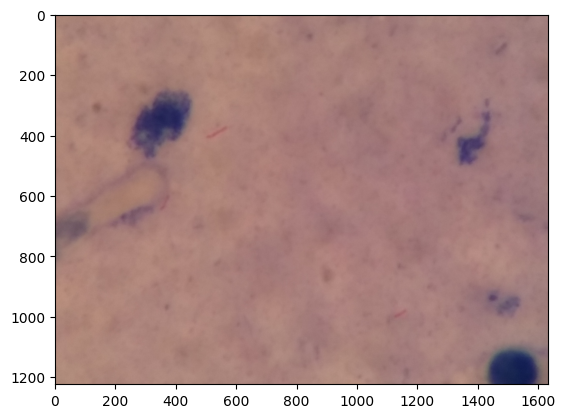

In [3]:
# apply transforms to first image and display it
img = dataset._images[0]
print(img.numpy().shape)
plt.imshow(img.numpy())

In [4]:
img.artifact.uri

'data/tuberculosis-phonecamera/tuberculosis-phone-1001.jpg'

Image shape: torch.Size([800, 1066, 3])


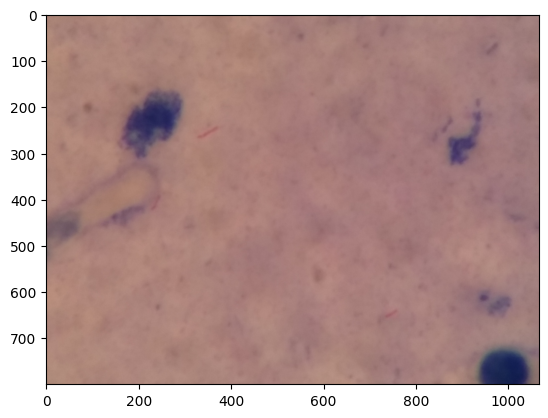

In [131]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
tr_img = transforms(img.pil())
tr_img = unnorm(tr_img).permute(1, 2, 0)

print(f"Image shape: {tr_img.size()}")
plt.imshow(tr_img)

In [90]:
# 2. load model
# load the model from checkpoint
checkpoint_path = 'bacili_detection/detr/outputs/checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=False, num_classes=2)
model.load_state_dict(checkpoint['model'])
print("checkpoint loaded at epoch", checkpoint['epoch'])
model.eval();

Using cache found in /Users/simon/.cache/torch/hub/facebookresearch_detr_main
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


checkpoint loaded at epoch 14


/var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/ipykernel_55660/4174211365.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


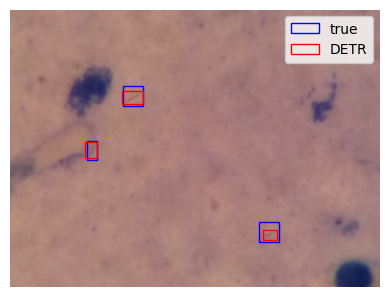

In [91]:
# see how the model performs on a single image
image = dataset._images[0]
boxes = detr_inference([image.pil()], model,  transform=transforms, labels=False)
boxes = [Rect.from_bbox(box, bbox_format='xyxy') for box in boxes[0]]
fig, ax = plt.subplots(1, figsize=(4, 4))
image.display(color='blue', ax=ax, label='true')
for i, box in enumerate(boxes):
    box.plot(ax=ax, color='red', label='DETR' if i == 0 else None)
ax.legend()
fig.show()

In [92]:
# 3. load the dataset of images and annotations that we will use to train the loss prediction model
# i.e same images and annotations that we used to train the DETR model (train, val, test splits)
tr_dataset = TBBacilliDataset(['train', 'test', 'val'], transform=make_ds_transforms('val', includes_target=True))
print(f"Found {len(tr_dataset)} labeled images")

Found 301 labeled images


In [93]:
#  4. We now need to get the losses for each image in the training set to use as our target variable

# 4.1. get the losses for each image in the training set
batch_size = 1
stop_at = None # for testing purposes, stop after this many images

args = get_args_parser().parse_args([]) # get the default arguments
criterion = build_criterion(args) # build the criterion
dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
losses_dict = compute_losses(model, criterion, dataloader, device='cpu', notebook=True, stop_at=stop_at)

In [170]:
# save the losses to a json file
save_file = f'bacili_detection/active_learning/losses/detr_losses-bs{batch_size}.json'
Path(save_file).parent.mkdir(parents=True, exist_ok=True)
json.dump(losses_dict, open(save_file, 'w'))
df = pd.DataFrame.from_dict(losses_dict, orient='index')
df = pd.concat([df.drop(columns=['loss_dict']), df.loss_dict.apply(pd.Series)], axis=1)\
    .assign(
        tags=lambda df: df.image_ids.apply(lambda l: {t.tag for i in l for t in tr_dataset._images[i].artifact.tags}),
    )
df.sort_values('loss', ascending=False).head()

,image_ids,image_db_ids,loss,loss_ce,loss_bbox,loss_giou,tags
9,[9],[12],2.349391,0.066994,0.145412,0.777669,{test}
79,[79],[306],1.706157,0.554367,0.030088,0.500675,{val}
85,[85],[330],1.660114,0.501754,0.036807,0.487162,{test}
204,[204],[875],1.624580,0.492299,0.030962,0.488737,{test}
1,[1],[3],1.600451,0.030222,0.060908,0.632844,{train}


Image(s) with highest loss ([9]):


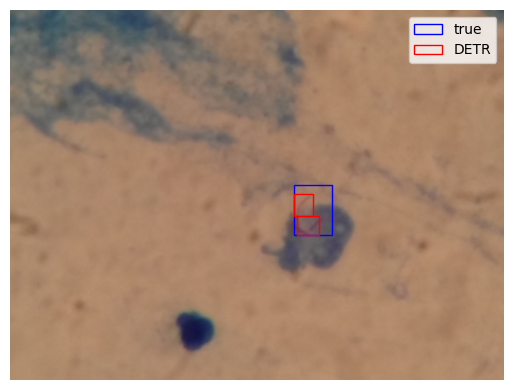

In [177]:
# which image(s) corresponds to the highest loss?
image_ids_highest = df.sort_values('loss', ascending=False).image_ids.iloc[0]
images = [tr_dataset._images[i] for i in image_ids_highest]
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
axes = [axes] if len(images) == 1 else axes
pred_boxes = detr_inference([im.pil() for im in images], model,  transform=transforms, labels=False)
for i, image in enumerate(images):
    image.display(color='blue', ax=axes[i], label='true')
    for j, box in enumerate(pred_boxes[i]):
        box = Rect.from_bbox(box, bbox_format='xyxy')
        box.plot(ax=axes[i], color='red', label='DETR' if j == 0 else None)
    axes[i].legend()
print(f'Image(s) with highest loss ({image_ids_highest}):')
fig.tight_layout()

The list of losses of each image is what we'll use as the target to our loss-prediction model.

### Build the features of the model

In [85]:
# 5. build the features for each image in the training set
## What we consider as features is up to us. Here we use the following:
# - the output features from the CNN backbone of DETR (i.e. the output of the fine-tuned ResNet50)
# - the output features of the transformer encoder of DETR
# - the output features of the transformer decoder of DETR -> this is almost equivalent to full inference of DETR, so we'll try to avoid it

# 5.1. get the features from the CNN backbone of DETR

# get the features from the CNN backbone of DETR
from typing import List
from bacili_detection.detr.util.misc import nested_tensor_from_tensor_list
from bacili_detection.detr.models import detr_inference
from bacili_detection.detr.models.detr import PostProcess
from tqdm.notebook import tqdm

# get the features from the CNN backbone of DETR
def compute_features(images:List, model, transform, device='cpu'):
    sample = [transform(image) for image in images]
    sample = nested_tensor_from_tensor_list(sample)
    sample = sample.to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        features, pos = model.backbone(sample)
        src, _ = features[-1].decompose()
        src, pos = model.input_proj(src), pos[-1]
    return src, pos

ModuleNotFoundError: No module named 'util'

In [ ]:
# get the features from the CNN backbone of DETR
features_size = (256, 25, 34)
features = torch.zeros((len(tr_dataset), *features_size))
positional_encodings = torch.zeros((len(tr_dataset), *features_size))
step=1 # process images in batches of 25
for i in tqdm(range(0, len(tr_dataset), step)):
    images = [tr_dataset._images[j].pil() for j in range(i, min(i+step, len(tr_dataset)))]
    src, pos = compute_features(images, model, transforms, device='cpu')
    features[i:i+step] = src
    positional_encodings[i:i+step] = pos

In [302]:
# save as torch tensor
save_file_f = f'bacili_detection/active_learning/features/detr-bs{batch_size}_features.pt'
save_file_p = f'bacili_detection/active_learning/features/detr-bs{batch_size}_positional.pt'
Path(save_file_f).parent.mkdir(parents=True, exist_ok=True)
torch.save(features, save_file_f)
torch.save(positional_encodings, save_file_p)

In [303]:
# size of the features file
print(f"Size of features file: {Path(save_file_f).stat().st_size / 1e6:.2f} MB")
print(f"Size of positional encodings file: {Path(save_file_p).stat().st_size / 1e6:.2f} MB")

Size of features file: 261.99 MB
Size of positional encodings file: 261.99 MB


Build a DNN model that takes the input features of the model and outputs the loss of the model.

In [83]:
# 5. build a DNN that takes the features as input and outputs the loss
from torch import nn
import torch, json
from bacili_detection.detr.util.misc import nested_tensor_from_tensor_list
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

class DETRLossPredictor(nn.Module):
    """
    A simple DNN that takes the features from the CNN backbone of DETR as input and outputs the loss

    Since the input is the output to a convolutional layer of size 254x(MxN), we first flatten the input
    and then pass it through two fully connected layers with ReLU activation. The output is a single number
    to 1 (the loss).
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    @torch.no_grad()
    def predict(self, x:dict):
        return self.forward(x).detach().numpy()
    
    @torch.no_grad()
    def predict_from_image(self, image, model, transform, device='cpu'):
        src, pos = compute_features([image], model, transform, device=device)
        return self.predict(src)

# 6. train the DNN

# 6.1. prepare the data
# get the features and losses
batch_size = 1
save_file_f = f'bacili_detection/active_learning/features/detr-bs{batch_size}_features.pt'
save_file_p = f'bacili_detection/active_learning/features/detr-bs{batch_size}_positional.pt'
features = torch.load(save_file_f)
# pos_encodings = torch.load(save_file_p)
losses = json.load(open(f'bacili_detection/active_learning/losses/detr_losses-bs{batch_size}.json', 'r'))
losses = torch.tensor([losses[f'{i}']['loss'] for i in range(len(losses))], requires_grad=False).reshape(-1, 1)
# detach if necessary
features = features.detach()
losses = losses.detach()
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, losses, test_size=0.15, random_state=42)

In [60]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 6.2. set up the model
batch_size = 8
num_epochs = 100
stop_patience = np.inf # number of epochs to wait before early stopping
lrs_patience = 3 # number of epochs to wait before reducing the learning rate
eval_every = 5 # evaluate the model every x epochs and print loss/metrics

features_size = (256, 25, 34)
model = DETRLossPredictor(input_size=features_size, hidden_size=100, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lrs_patience, verbose=True, factor=0.1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
# early stopping
best_loss = np.inf
patience_counter = 0

In [61]:
# logging and experiment tracking with wandb
import wandb
wandb.init(project="bacilli-detection" , config={
    "model": "loss-prediction:detr",
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "num_train": len(X_train),
    "num_test": len(X_test),
    "input_size": features_size,
    "optimizer": optimizer.__class__.__name__,
})
wandb.watch(model)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████▅
lr,▁▁▁▁▁▁▁
r2_score,▁████████████
tain_loss,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▁▁▁▁▁▁
epoch,20
lr,0.001
r2_score,-22.73476
tain_loss,1.34874
test_loss,1.17438


[]

In [69]:
# 6.3. train the model until convergence
at_sample_seen = 0 
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for ind, (X, y) in enumerate(train_loader):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        at_sample_seen += len(X)
        if ind % 10 == 0:
            wandb.log({"epoch": epoch, "tain_loss": loss.item()}, step=at_sample_seen)
    train_loss /= len(train_loader)
    if epoch % eval_every != 0:
        continue
    model.eval()
    test_loss = 0
    ys, y_preds = [], []
    for X, y in test_loader:
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_loss += loss.item()
        ys.append(y.detach().numpy())
        y_preds.append(y_pred.detach().numpy())
    test_loss /= len(test_loader)
    lr_scheduler.step(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}')
    r2 = r2_score(np.concatenate(ys), np.concatenate(y_preds))
    print(f'test R2 score: {r2:.2f}')
    wandb.log({"epoch": epoch, "r2_score": r2})
    wandb.log({"test_loss": test_loss, "epoch": epoch, "lr": optimizer.param_groups[0]['lr']}, step=at_sample_seen)
    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= stop_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: train_loss=0.14, test_loss=0.17
test R2 score: -0.51
Epoch 6/100: train_loss=0.12, test_loss=0.16
test R2 score: -0.40
Epoch 00024: reducing learning rate of group 0 to 3.2000e-07.
Epoch 11/100: train_loss=0.11, test_loss=0.15
test R2 score: -0.30
Epoch 16/100: train_loss=0.11, test_loss=0.15
test R2 score: -0.28
Epoch 21/100: train_loss=0.11, test_loss=0.14
test R2 score: -0.26
Epoch 26/100: train_loss=0.11, test_loss=0.14
test R2 score: -0.24
Epoch 00028: reducing learning rate of group 0 to 6.4000e-08.
Epoch 31/100: train_loss=0.10, test_loss=0.14
test R2 score: -0.22
Epoch 36/100: train_loss=0.10, test_loss=0.14
test R2 score: -0.22
Early stopping at epoch 36


In [70]:
# finish wandb run and show results
wandb.finish()
print(f'Best test loss: {best_loss:.2f}')


epoch,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██▁▁▁▂▂▂▂▃▃▃▄
lr,███████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r2_score,▅▆▇█▇▆█▂▃▇▆▁▇█▆▅▅▆▇██████████
tain_loss,▃▃▁▁▁▁▂▂▂▄▃▂█▁▄▁▅▃▁▂▂▃▃▂▃▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁
test_loss,▄▃▂▁▂▃▁▇▆▂▂█▂▁▃▄▄▃▂▁▁▁▁▁▁▁▁▁▁
epoch,35
lr,0.0
r2_score,-0.22411
tain_loss,0.067
test_loss,0.14075


Best test loss: 0.12


In [82]:
y, y_pred

(tensor([[1.4953],
         [1.0040]]),
 tensor([[1.0250],
         [1.0250]], grad_fn=<AddmmBackward0>))

Text(0.5, 1.0, 'Predicted vs true loss')

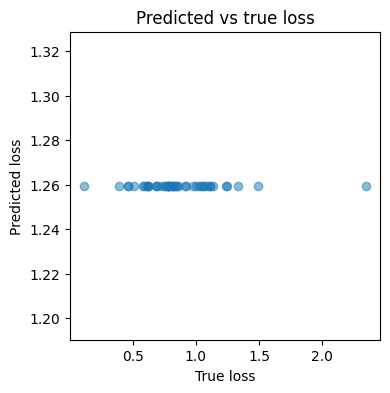

In [45]:
# 7. evaluate the model
# 7.1. get the predictions for the test set
import matplotlib.pyplot as plt
model.eval()
ys, y_preds = [], []
for X, y in test_loader:
    y_pred = model(X)
    ys.append(y.detach().numpy())
    y_preds.append(y_pred.detach().numpy())

# 7.2. plot the predictions vs the true values
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.scatter(np.concatenate(ys), np.concatenate(y_preds), alpha=0.5)
ax.set_xlabel('True loss')
ax.set_ylabel('Predicted loss')
ax.set_title('Predicted vs true loss')

In [320]:
model.parameters()

<generator object Module.parameters at 0x2f00ce510>

In [322]:
loss.item()

0.7760260701179504

In [309]:
features_size[0]

256

In [311]:
X.size()

torch.Size([32, 256, 25, 34])

model.backbone